In [1]:
# Importing all the libraries needed.

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import pandas as pd
import os, requests, cv2, random

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

from tensorflow.keras import models
from tensorflow.keras import Sequential, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from sklearn.metrics import confusion_matrix,classification_report
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [2]:
train_data_dir =  r"C:\Users\dell\Desktop\archive\ethiopian cofee leaf dataset\train aug"
test_data_dir =  r"C:\Users\dell\Desktop\archive\ethiopian cofee leaf dataset\test" 

In [3]:
#C_N means class_name
C_N = sorted(os.listdir(train_data_dir))
C_N

['Cerscospora', 'Healthy', 'Leaf rust', 'Phoma']

In [4]:
IMG_SIZE = (256, 256)  # specify your desired image size

train_datagen = ImageDataGenerator(
                                    rescale=1/255.0,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    validation_split=0.1)  # specifying the validation split inside the function

test_datagen = ImageDataGenerator(
                                   rescale=1/255.0,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

In [5]:
train_gen = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=IMG_SIZE,
    batch_size=32,
    shuffle=True,
    class_mode='categorical',
    subset='training')

Found 9720 images belonging to 4 classes.


In [6]:
val_gen = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=IMG_SIZE,
    batch_size=32,
    shuffle=True,
    class_mode='categorical',
    subset='validation')

Found 1080 images belonging to 4 classes.


In [7]:
test_gen = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='categorical',
    shuffle=False)  # shuffle will not affect the accuracy of the model, but will affect the computation of some metrics that depend on the order of the samples

Found 1200 images belonging to 4 classes.


In [8]:
def display_random_images(data, class_names, num_images=12, figsize=(10, 6)):
    plt.figure(figsize=figsize)
    
    # Get an iterator for the data generator
    data_iter = iter(data)

    for i in range(num_images):
        images, labels = next(data_iter)
        plt.subplot(3, 4, i + 1)
        plt.imshow(images[0]) 
        plt.title(class_names[np.argmax(labels[0])])
        plt.axis('off')  # Turn off axis labels and ticks

    plt.show()

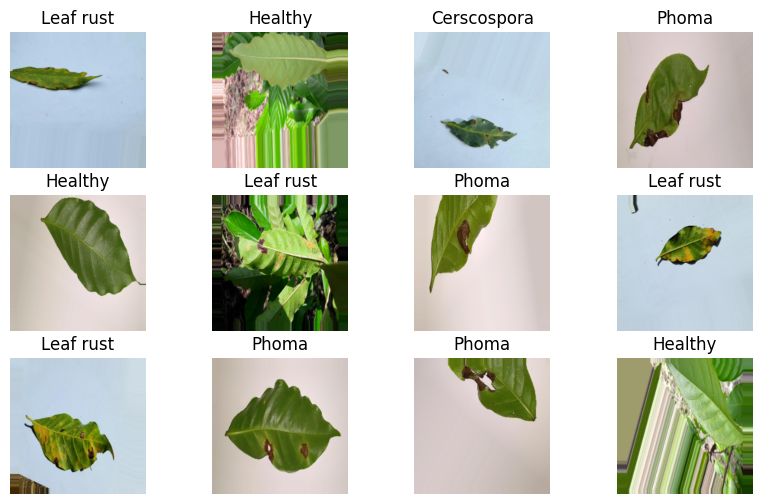

In [9]:
display_random_images(train_gen, class_names=C_N)

In [10]:
# Create a Sequential model
model = Sequential()

# Add Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten layer
model.add(Flatten())

# Dense layers
model.add(Dense(128, activation='relu'))
model.add(Dense(4, activation='softmax'))

model.summary() 

c:\Users\dell\Desktop\fruit_detection\fruit_detection\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,839,492 (56.61 MB)

 Trainable params: 14,839,492 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Creating the optimizer
opt = keras.optimizers.Adam(learning_rate=0.001)

# Compile the model with the specified optimizer and loss function

model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
import warnings
from PIL import Image
from keras.callbacks import EarlyStopping

# Set a higher threshold for the decompression bomb warning
warnings.filterwarnings("ignore", category=Image.DecompressionBombWarning)

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(
    x=train_gen,
    epochs=5,
    verbose=1,
    steps_per_epoch=len(train_gen),
    validation_data=val_gen,
    validation_steps=len(val_gen),
    callbacks=[early_stopping]  
)

c:\Users\dell\Desktop\fruit_detection\fruit_detection\env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
304/304 ━━━━━━━━━━━━━━━━━━━━ 940s 3s/step - accuracy: 0.6688 - loss: 0.9400 - val_accuracy: 0.5750 - val_loss: 1.1739
Epoch 2/5
304/304 ━━━━━━━━━━━━━━━━━━━━ 848s 3s/step - accuracy: 0.8502 - loss: 0.3992 - val_accuracy: 0.7861 - val_loss: 0.5322
Epoch 3/5
304/304 ━━━━━━━━━━━━━━━━━━━━ 804s 3s/step - accuracy: 0.8840 - loss: 0.3067 - val_accuracy: 0.8796 - val_loss: 0.3030
Epoch 4/5
304/304 ━━━━━━━━━━━━━━━━━━━━ 817s 3s/step - accuracy: 0.9173 - loss: 0.2479 - val_accuracy: 0.9130 - val_loss: 0.2495
Epoch 5/5
304/304 ━━━━━━━━━━━━━━━━━━━━ 793s 3s/step - accuracy: 0.9309 - loss: 0.2004 - val_accuracy: 0.9463 - val_loss: 0.1559


In [13]:
scores = model.evaluate(test_gen)

38/38 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.9788 - loss: 0.0738


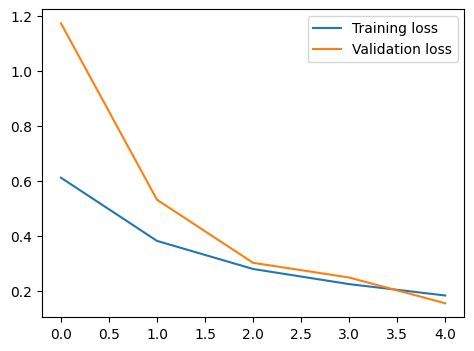

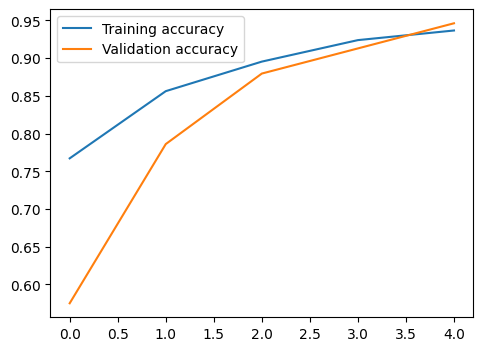

In [14]:
# plot the loss

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

# Plot the accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.show()


In [47]:
model.save('final_code.keras')


In [48]:
from tensorflow.keras.models import load_model

loaded_model = load_model('final_code.keras')
loaded_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,518,478 (169.82 MB)

 Trainable params: 14,839,492 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 29,678,986 (113.22 MB)

In [22]:
model.save_weights("model_weights.weights.h5")

In [23]:
from tensorflow.keras.models import load_model

model.load_weights("model_weights.weights.h5")

In [45]:
from tensorflow.keras.models import load_model
import joblib

# Save the Keras model using joblib
model_file = "model_with_joblib.pkl"
joblib.dump(model, model_file)

print(f"Model saved to {model_file}")


Model saved to model_with_joblib.pkl


In [46]:
# Load the Keras model using joblib
loaded_model = joblib.load(model_file)

# Check the summary to confirm successful loading
loaded_model.summary()


c:\Users\dell\Desktop\fruit_detection\fruit_detection\env\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,518,478 (169.82 MB)

 Trainable params: 14,839,492 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 29,678,986 (113.22 MB)

In [25]:
test_steps_per_epoch = np.ceil(test_gen.samples / test_gen.batch_size).astype(int)

# Predict classes
predictions = model.predict(test_gen, steps=test_steps_per_epoch)
predicted_classes = np.argmax(predictions,axis=1)

38/38 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step


In [26]:
true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

38/38 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step
Confusion Matrix (NumPy Array):
[[299   0   1   0]
 [  0 300   0   0]
 [ 14  36 250   0]
 [  1   7   1 291]]


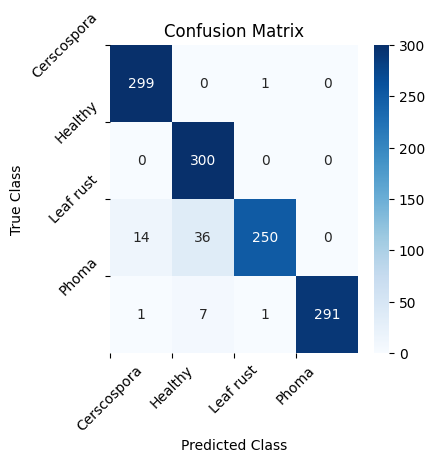

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming we have predictions and true labels from our model
y_pred_probs = model.predict(test_gen, steps=len(test_gen)) 
y_pred = model.predict(test_gen)
y_true = test_gen.classes

# Calculate the confusion matrix
cm = confusion_matrix(y_true, np.argmax(y_pred, axis=1))

# Display the confusion matrix as a NumPy array
print("Confusion Matrix (NumPy Array):")
print(cm)

# Create a visualization of the confusion matrix with class names
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues)

# Set class names as tick labels
class_names = ["Cerscospora", "Healthy", "Leaf rust", "Phoma"]
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names, rotation=45)

plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")

plt.show()

In [28]:
# Generate a detailed classification report
detailed_report = classification_report(true_classes, predicted_classes, target_names=class_labels)

# Print the report for analysis
print(detailed_report)

              precision    recall  f1-score   support

 Cerscospora       0.94      1.00      0.97       300
     Healthy       0.88      1.00      0.93       300
   Leaf rust       0.99      0.82      0.90       300
       Phoma       1.00      0.97      0.99       300

    accuracy                           0.95      1200
   macro avg       0.95      0.95      0.95      1200
weighted avg       0.95      0.95      0.95      1200



In [33]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def predict_images(data, class_names, model, num_images=12, figsize=(10, 6)):
   
    plt.figure(figsize=figsize)

    for i in range(num_images):
        # Fetch a batch of data
        images, labels = next(iter(data))
        id = np.random.randint(len(images))  # Randomly select an image
        img = tf.expand_dims(images[id], axis=0)  # Expand dims for model input

        plt.subplot(3, 4, i + 1)  # Create subplot grid
        plt.imshow(images[id])  # Display the image directly

        # Predict using the model
        prediction_probs = model.predict(img)[0]
        predicted_index = np.argmax(prediction_probs)
        predicted_label = class_names[predicted_index]
        predicted_confidence = prediction_probs[predicted_index] * 100  # Confidence in %

        # Get the actual label
        actual_label = class_names[np.argmax(labels[id])]

        # Title color based on prediction correctness
        title_color = "green" if predicted_label == actual_label else "red"

        # Set title with prediction details
        plt.title(
            f"Actual: {actual_label}\n"
            f"Predicted: {predicted_label} ({predicted_confidence:.2f}%)",
            fontsize=10,
            color=title_color,
        )
        plt.axis("off")  # Hide axes

    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 867ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


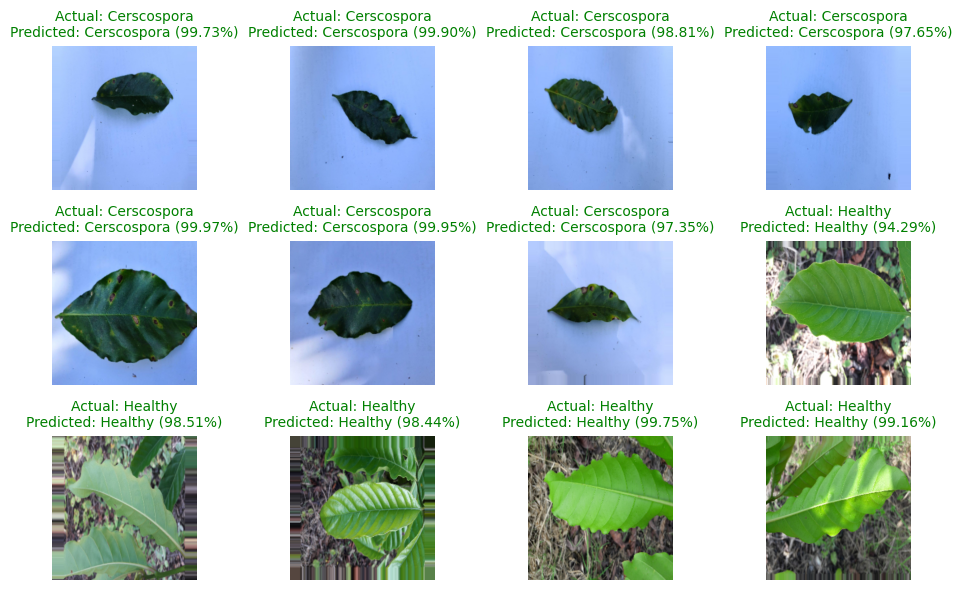

In [34]:
predict_images(test_gen, class_names, model)

In [53]:
# To load the model
from tensorflow.keras.models import load_model

loaded_model = load_model('final_code.keras')

In [54]:
from PIL import Image
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load the pre-trained model
model = load_model('final_code.keras')

# Function to preprocess the image for prediction
def preprocess_image(img_path):
    img = Image.open(img_path).convert('RGB')
    img = img.resize((256, 256))  # Updated size
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize the image
    return img_array

# Function to predict the disease and print the image
def predict_and_print(image_path, model):
    img = preprocess_image(image_path)
    prediction = model.predict(img)

    # Assuming you have a list of class names
    class_names = ["Cerscospora", "Healthy", "Leaf rust", "Phoma"]  # Replace with your actual class names
    predicted_class = class_names[np.argmax(prediction)]

    # Print the predicted class
    print(f"It is a {predicted_class} Cofee Leaf Disase")

    # Display the image
    plt.imshow(Image.open(image_path))
    plt.title(f"Predicted Class: {predicted_class}")
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
It is a Leaf rust Cofee Leaf Disase


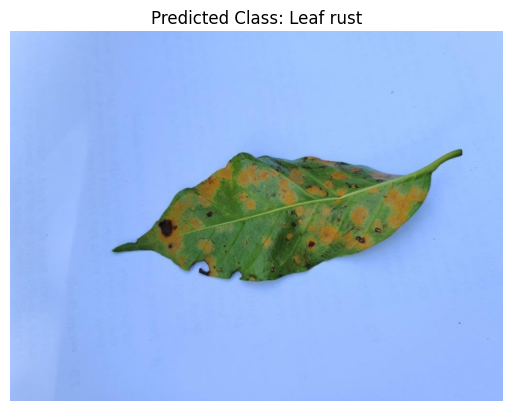

In [56]:
image_path_to_predict = r'C:\Users\dell\Desktop\archive\ethiopian cofee leaf dataset\test\Leaf rust/20231123_103017.jpg'
predict_and_print(image_path_to_predict, model)

In [57]:
import os
import glob

# Define the pattern for images in subdirectories
path_pattern = r"C:\Users\dell\Desktop\archive\ethiopian cofee leaf dataset\test/**/*.jpg"

# Debug: Check if the main directory exists
print("Directory exists:", os.path.exists(r"C:\Users\dell\Desktop\archive\ethiopian cofee leaf dataset\test"))

# Use glob to get all matching file paths
filepaths = glob.glob(path_pattern, recursive=True)

# Print the first 10 file paths
print("Found files:", filepaths[:2])



Directory exists: True
Found files: ['C:\\Users\\dell\\Desktop\\archive\\ethiopian cofee leaf dataset\\test\\Cerscospora\\20231123_102720 (2).jpg', 'C:\\Users\\dell\\Desktop\\archive\\ethiopian cofee leaf dataset\\test\\Cerscospora\\20231123_102724 (2).jpg']


In [58]:
import pandas as pd
import numpy as np

# Ensure y_true and y_pred are integer class indices
y_true = np.argmax(y_true, axis=1) if len(y_true.shape) > 1 else np.array(y_true, dtype=int)
y_pred = np.argmax(y_pred, axis=1) if len(y_pred.shape) > 1 else np.array(y_pred, dtype=int)

# Validate lengths
if len(filepaths) != len(y_true):
    raise ValueError("Number of file paths does not match number of true labels!")

# Create the DataFrame
pred_df = pd.DataFrame({
    "image_path": filepaths,
    "y_true": y_true,
    "y_pred": y_pred,
    "pred_conf": y_pred_probs.max(axis=1),  # Max confidence for predictions
    "y_true_classname": [class_names[i] for i in y_true],
    "y_pred_classname": [class_names[i] for i in y_pred]
})

# Display the DataFrame
print(pred_df)


                                             image_path  y_true  y_pred  \
0     C:\Users\dell\Desktop\archive\ethiopian cofee ...       0       0   
1     C:\Users\dell\Desktop\archive\ethiopian cofee ...       0       0   
2     C:\Users\dell\Desktop\archive\ethiopian cofee ...       0       0   
3     C:\Users\dell\Desktop\archive\ethiopian cofee ...       0       0   
4     C:\Users\dell\Desktop\archive\ethiopian cofee ...       0       0   
...                                                 ...     ...     ...   
1195  C:\Users\dell\Desktop\archive\ethiopian cofee ...       3       3   
1196  C:\Users\dell\Desktop\archive\ethiopian cofee ...       3       1   
1197  C:\Users\dell\Desktop\archive\ethiopian cofee ...       3       3   
1198  C:\Users\dell\Desktop\archive\ethiopian cofee ...       3       1   
1199  C:\Users\dell\Desktop\archive\ethiopian cofee ...       3       3   

      pred_conf y_true_classname y_pred_classname  
0      0.964913      Cerscospora      Cerscospo

In [59]:
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

,image_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
0,C:\Users\dell\Desktop\archive\ethiopian cofee ...,0,0,0.964913,Cerscospora,Cerscospora,True
1,C:\Users\dell\Desktop\archive\ethiopian cofee ...,0,0,0.985766,Cerscospora,Cerscospora,True
2,C:\Users\dell\Desktop\archive\ethiopian cofee ...,0,0,0.999205,Cerscospora,Cerscospora,True
3,C:\Users\dell\Desktop\archive\ethiopian cofee ...,0,0,0.999836,Cerscospora,Cerscospora,True
4,C:\Users\dell\Desktop\archive\ethiopian cofee ...,0,0,0.995537,Cerscospora,Cerscospora,True


In [60]:
top_wrong_pred = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_wrong_pred.head(10)

,image_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
797,C:\Users\dell\Desktop\archive\ethiopian cofee ...,2,1,0.998877,Leaf rust,Healthy,False
722,C:\Users\dell\Desktop\archive\ethiopian cofee ...,2,0,0.998769,Leaf rust,Cerscospora,False
758,C:\Users\dell\Desktop\archive\ethiopian cofee ...,2,0,0.997842,Leaf rust,Cerscospora,False
912,C:\Users\dell\Desktop\archive\ethiopian cofee ...,3,0,0.997692,Phoma,Cerscospora,False
815,C:\Users\dell\Desktop\archive\ethiopian cofee ...,2,1,0.996988,Leaf rust,Healthy,False
817,C:\Users\dell\Desktop\archive\ethiopian cofee ...,2,1,0.989048,Leaf rust,Healthy,False
878,C:\Users\dell\Desktop\archive\ethiopian cofee ...,2,1,0.987070,Leaf rust,Healthy,False
795,C:\Users\dell\Desktop\archive\ethiopian cofee ...,2,1,0.985290,Leaf rust,Healthy,False
873,C:\Users\dell\Desktop\archive\ethiopian cofee ...,2,1,0.973746,Leaf rust,Healthy,False
812,C:\Users\dell\Desktop\archive\ethiopian cofee ...,2,1,0.967390,Leaf rust,Healthy,False


In [61]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_and_prep_image(image_path, target_size=(224, 224), scale=True):
    
    # Load the image with the target size
    img = load_img(image_path, target_size=target_size)
    
    # Convert the image to an array
    img_array = img_to_array(img)
    
    # Optionally scale the pixel values
    if scale:
        img_array = img_array / 255.0
    
    return img_array


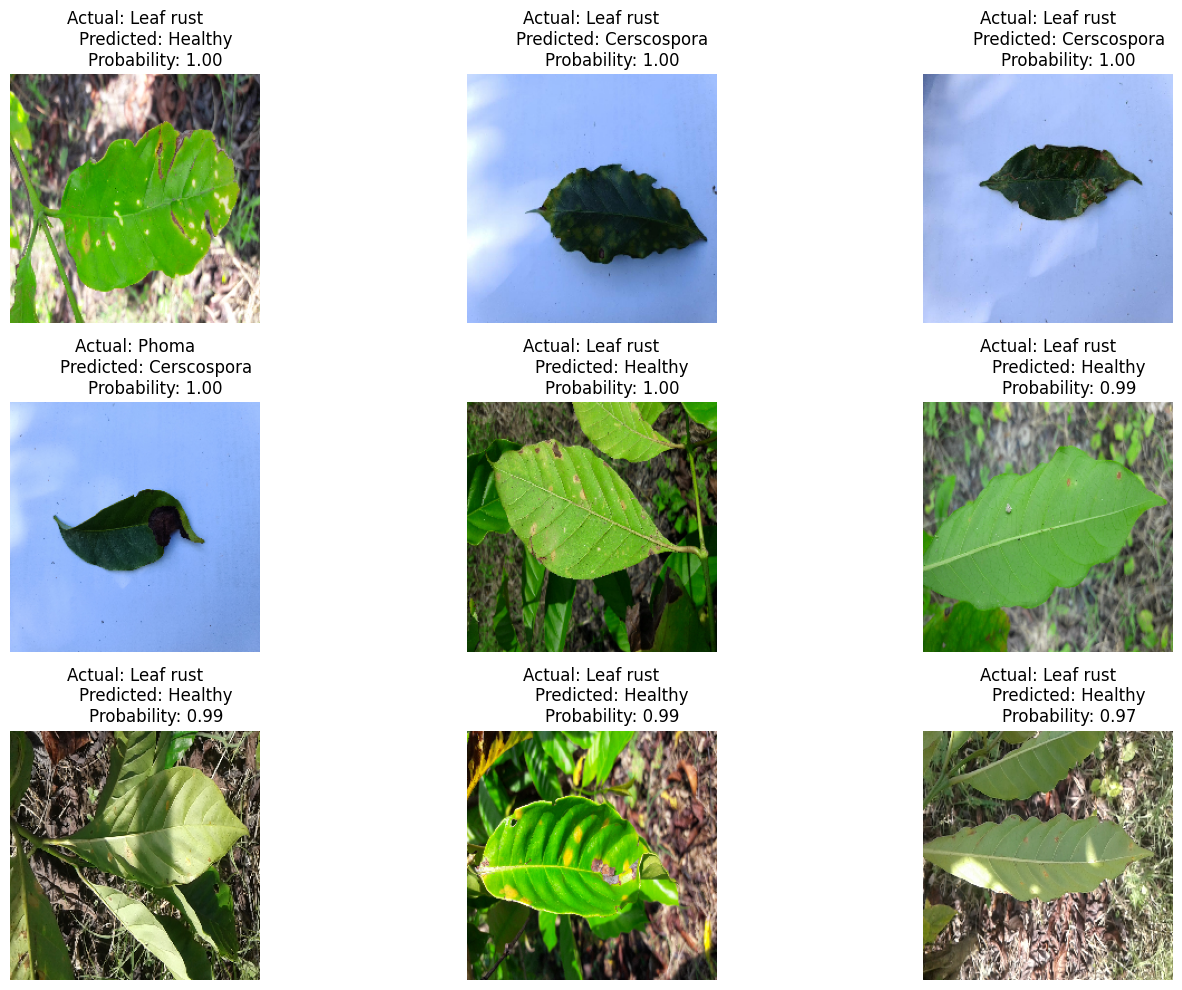

In [62]:
images_to_view = 9
start_index = 0

plt.figure(figsize=(15, 10))

for i, row in enumerate(top_wrong_pred[start_index:start_index + images_to_view].itertuples()):
    plt.subplot(3, 3, i + 1)
    
    # Load and preprocess the image
    img = load_and_prep_image(row.image_path, scale=False)
    
    # Unpack required row values
    _, _, _, _, pred_prob, y_true_classname, y_pred_classname, _ = row
    
    # Display the image
    plt.imshow(img / 255.0)
    plt.title(
        f"""Actual: {y_true_classname}
        Predicted: {y_pred_classname}
        Probability: {pred_prob:.2f}"""
    )
    plt.axis(False)

plt.tight_layout()
plt.show()

